# Capstone - Delivery-2
This dataset is part of the [Farming Systems Project](https://www.ars.usda.gov/northeast-area/beltsville-md-barc/beltsville-agricultural-research-center/sustainable-agricultural-systems-laboratory/docs/farming-systems-project/) at USDA, Beltsville MD.  This data is not available online on the USDA
 website but can be found on my [GitHub](https://github.com/mmtokay/DATA606/tree/master/datasets).


The data is split in two files, one that contains crop information and other with weather data.

Crop file:
* Crop - wheat, corn or soybean           
* GrowingSeason - year crop was cultivated 
* SystemName - crop management (traditional: NT, CT, 3 and 4; organic: Org2, Org3 and Org6')    
* GrainYield - grain yield measured in kg/ha     
* PlantingDate - date seeds were planted  
* HarvestDate - date crop was harvested


Weather file:
* Year 
* Julian Day 
* Month
* Day
* Date
* avgtTempC - average temperature in C
* maxTempC - maximum temperature in C
* minTempC - minimum temperature in C
* maxHumPct - maximum humidity in %
* minHumPct - minimum humidity in %
* avgRadWm-2 - average radiation in w/m2
* meanWindMs-1 - mean wind in m/s
* PrecipitationMm - precipitation/snow melt in mm

# Exploratory Data Analysis (Preliminary)


In [0]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests # requests is a handy http library
import seaborn as sns
import warnings
import zipfile # a zip library

from datetime import datetime, timedelta
from __future__ import print_function
from google.colab import files, drive

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Crop Data
Import crop data file.

In [3]:
data = pd.read_csv('gdrive/My Drive/DATA606/datasets/FSPGrainYieldsV2Clean.csv')
data.head()

,Crop,GrowingSeason,SystemName,GrainYield,PlantingDate,HarvestDate
0,CRN,1996,NT,10488.0,5/23/1996,10/17/1996
1,CRN,1996,NT,9722.5,5/23/1996,10/17/1996
2,CRN,1996,NT,10008.0,5/23/1996,10/17/1996
3,CRN,1996,NT,8928.8,5/23/1996,10/17/1996
4,CRN,1996,CT,10985.3,5/23/1996,10/17/1996


Data information.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 6 columns):
Crop             1166 non-null object
GrowingSeason    1166 non-null int64
SystemName       1166 non-null object
GrainYield       1166 non-null float64
PlantingDate     1166 non-null object
HarvestDate      1071 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 54.8+ KB


Data contains 6 columns and 1166 rows.

Data conversion:
*   Convert GrainYield to numeric.
*   Convert PlantingDate and HarvestDate to datetime.



In [0]:
# Convert from object to float64
data['GrainYield'] = pd.to_numeric(data.GrainYield, errors='coerce')

# Convert PlantingDate and HarvestDate from object to date
data['PlantingDate'] = pd.to_datetime(data.PlantingDate)
data['HarvestDate'] = pd.to_datetime(data.HarvestDate)

Let's check if there is any data missing on the dataset.  

In [6]:
data.isna().sum()

Crop              0
GrowingSeason     0
SystemName        0
GrainYield        0
PlantingDate      0
HarvestDate      95
dtype: int64

I don't have harvest date for 95 measurements.  Harvest date is not critical because often times the crop is not harvest as soon as the crop is mature.  It is important to know how long each crop takes to mature on average.  I will create a new column called weekDuration to calculate the week duration between planting date and harvest date.

In [0]:
# Calculate duration between PlantingDate and HarvestDate
data['weekDuration'] = data['HarvestDate'] - data['PlantingDate']
data['weekDuration'] = data['weekDuration']/np.timedelta64(1,'W')

Check unique values for Crop, GrowingSeason and SystemName columns.

In [8]:
print("Crop", data.Crop.unique())
print("\nGrowing Season", data.GrowingSeason.unique())
print("\nCrop Management Type", data.SystemName.unique())

Crop ['CRN' 'SOY' 'WHT']

Growing Season [1996 1997 1998 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016]

Crop Management Type ['NT' 'CT' '3' '4' 'Org2' 'Org3' 'Org6' 'ORG2' 'ORG3' 'ORG6']


There are duplicate values for SystemManagement because column values are case sensitive.  I will convert SystemName column to uppercase.

**Note:** There is no data for 1999 because it was a dry year and this experiment doesn't use irrigation, crops never matured.

In [9]:
data['SystemName'] = data['SystemName'].str.upper()
print("\nCrop Management Type", data.SystemName.unique())


Crop Management Type ['NT' 'CT' '3' '4' 'ORG2' 'ORG3' 'ORG6']


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

I will separate the data by crop: corn, soybean and wheat and I will display basic statistics for each crop.

# Corn dataset - Statistics

In [11]:
data_corn = data.loc[data['Crop'] == "CRN"]
data_corn.describe(include="all")

,Crop,GrowingSeason,SystemName,GrainYield,PlantingDate,HarvestDate,weekDuration
count,407,407.000000,407,407.000000,407,379,379.000000
unique,1,NaN,7,NaN,43,64,NaN
top,CRN,NaN,ORG3,NaN,1996-05-23 00:00:00,2008-10-10 00:00:00,NaN
freq,407,NaN,80,NaN,16,20,NaN
first,NaN,NaN,NaN,NaN,1996-05-23 00:00:00,1996-10-17 00:00:00,NaN
last,NaN,NaN,NaN,NaN,2016-06-09 00:00:00,2016-10-18 00:00:00,NaN
mean,NaN,2005.985258,NaN,5723.638280,NaN,NaN,21.577836
std,NaN,6.106588,NaN,3343.778196,NaN,NaN,2.496042
min,NaN,1996.000000,NaN,71.900000,NaN,NaN,16.857143
25%,NaN,2001.000000,NaN,2798.000000,NaN,NaN,19.428571


Corn Data Distribution by Year

In [12]:
data_corn_grouped = data_corn.groupby(['GrowingSeason'], as_index=False).agg({'GrainYield': "count"})
data_corn_grouped.head()

,GrowingSeason,GrainYield
0,1996,28
1,1997,17
2,1998,28
3,2000,20
4,2001,20


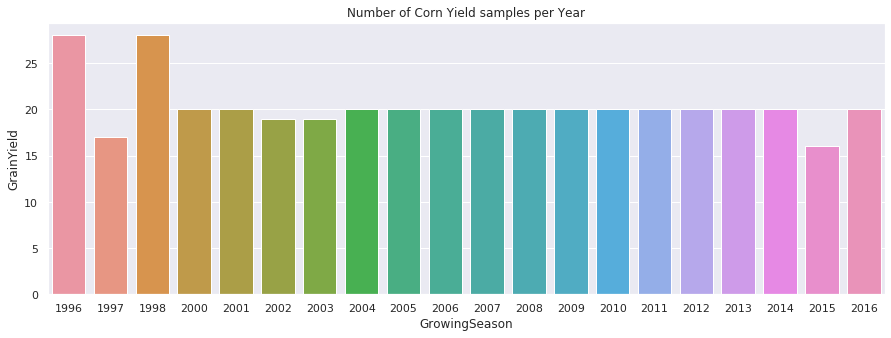

In [13]:
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
ax = sns.barplot(x = "GrowingSeason", y = "GrainYield", data = data_corn_grouped).set_title("Number of Corn Yield samples per Year")

Corn Data Distribution by Crop Management Type

In [14]:
data_corn_sys_grouped = data_corn.groupby(['SystemName'], as_index=False).agg({'GrainYield': "count"})
data_corn_sys_grouped.head()

,SystemName,GrainYield
0,3,9
1,4,8
2,CT,77
3,NT,79
4,ORG2,78


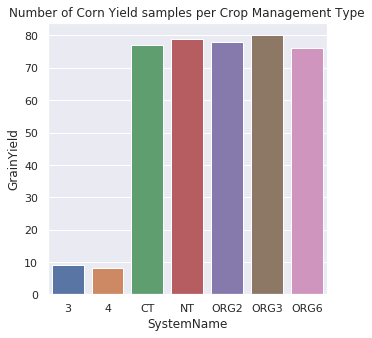

In [15]:
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
ax = sns.barplot(x = "SystemName", y = "GrainYield", data = data_corn_sys_grouped).set_title("Number of Corn Yield samples per Crop Management Type")

# Soybean dataset - Statistics

In [16]:
data_soy = data.loc[data['Crop'] == "SOY"]
data_soy.describe(include="all")

,Crop,GrowingSeason,SystemName,GrainYield,PlantingDate,HarvestDate,weekDuration
count,524,524.000000,524,524.000000,524,481,481.000000
unique,1,NaN,7,NaN,49,49,NaN
top,SOY,NaN,CT,NaN,2002-05-21 00:00:00,2013-10-29 00:00:00,NaN
freq,524,NaN,137,NaN,20,20,NaN
first,NaN,NaN,NaN,NaN,1996-05-23 00:00:00,1996-10-04 00:00:00,NaN
last,NaN,NaN,NaN,NaN,2016-07-14 00:00:00,2016-10-27 00:00:00,NaN
mean,NaN,2006.320611,NaN,2631.304962,NaN,NaN,21.103059
std,NaN,5.995559,NaN,1160.173841,NaN,NaN,2.850115
min,NaN,1996.000000,NaN,165.200000,NaN,NaN,15.000000
25%,NaN,2002.000000,NaN,1821.125000,NaN,NaN,19.142857


In [17]:
data_soy_grouped = data_soy.groupby(['GrowingSeason'], as_index=False).agg({'GrainYield': "count"})
data_soy_grouped.head()

,GrowingSeason,GrainYield
0,1996,28
1,1997,24
2,1998,28
3,2000,20
4,2001,28


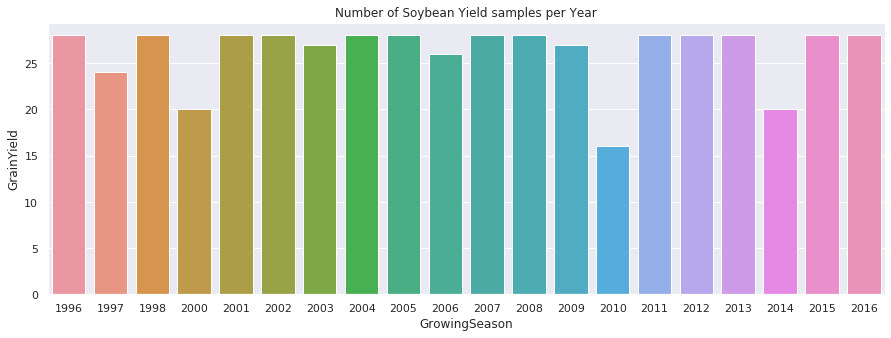

In [18]:
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
ax = sns.barplot(x = "GrowingSeason", y = "GrainYield", data = data_soy_grouped).set_title("Number of Soybean Yield samples per Year")

Soybean Data Distribution by Crop Management Type

In [19]:
data_soy_sys_grouped = data_soy.groupby(['SystemName'], as_index=False).agg({'GrainYield': "count"})
data_soy_sys_grouped.head()

,SystemName,GrainYield
0,3,12
1,4,12
2,CT,137
3,NT,136
4,ORG2,75


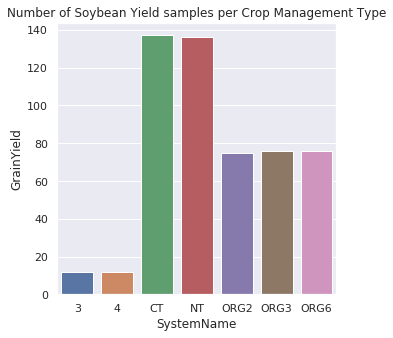

In [20]:
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
ax = sns.barplot(x = "SystemName", y = "GrainYield", data = data_soy_sys_grouped).set_title("Number of Soybean Yield samples per Crop Management Type")

# Wheat dataset - Statistics

In [21]:
data_wheat = data.loc[data['Crop'] == "WHT"]
data_wheat.describe(include="all")

,Crop,GrowingSeason,SystemName,GrainYield,PlantingDate,HarvestDate,weekDuration
count,235,235.000000,235,235.000000,235,211,211.000000
unique,1,NaN,6,NaN,19,15,NaN
top,WHT,NaN,CT,NaN,2001-10-26 00:00:00,2000-07-06 00:00:00,NaN
freq,235,NaN,58,NaN,16,20,NaN
first,NaN,NaN,NaN,NaN,1996-11-04 00:00:00,1997-07-06 00:00:00,NaN
last,NaN,NaN,NaN,NaN,2015-11-17 00:00:00,2016-07-11 00:00:00,NaN
mean,NaN,2007.123404,NaN,4283.482128,NaN,NaN,35.688558
std,NaN,6.256423,NaN,1086.303047,NaN,NaN,1.944146
min,NaN,1997.000000,NaN,1403.500000,NaN,NaN,31.428571
25%,NaN,2001.000000,NaN,3660.900000,NaN,NaN,34.857143


In [22]:
data_wheat_grouped = data_wheat.groupby(['GrowingSeason'], as_index=False).agg({'GrainYield': "count"})
data_wheat_grouped.head()

,GrowingSeason,GrainYield
0,1997,8
1,1998,24
2,2000,20
3,2001,16
4,2002,16


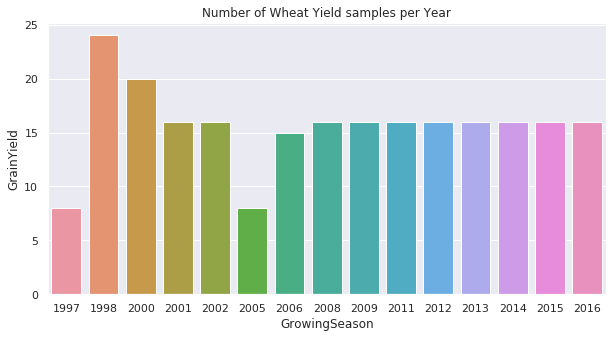

In [23]:
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax = sns.barplot(x = "GrowingSeason", y = "GrainYield", data = data_wheat_grouped).set_title("Number of Wheat Yield samples per Year")

Wheat Data Distribution by Crop Management Type

In [0]:
data_wheat_sys_grouped = data_wheat.groupby(['SystemName'], as_index=False).agg({'GrainYield': "count"})
data_wheat_sys_grouped.head()

,SystemName,GrainYield
0,3,8
1,4,4
2,CT,58
3,NT,57
4,ORG3,56


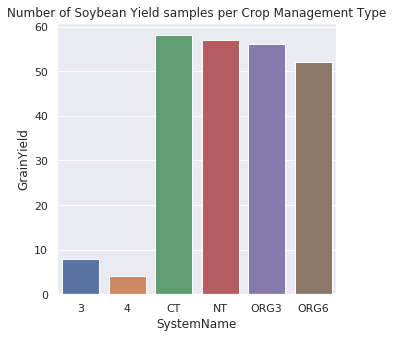

In [0]:
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
ax = sns.barplot(x = "SystemName", y = "GrainYield", data = data_wheat_sys_grouped).set_title("Number of Soybean Yield samples per Crop Management Type")

# Weather Data

Import weather data.

In [0]:
weather_data = pd.read_csv('gdrive/My Drive/DATA606/datasets/FSPWeather1996-2019V2.csv')
weather_data.head()

,Year,JulianDay,Month,Day,Date,avgtTempC,maxTempC,minTempC,maxHumPct,minHumPct,avgRadWm-2,meanWindMs-1,PrecipitationMm
0,1996,1,1,1,1/1/1996,3.3,4.2,2.4,100.5,91.5,12.6,1.4,1.3
1,1996,2,1,2,1/2/1996,3.2,3.9,1.9,101.0,99.4,8.9,2.4,7.6
2,1996,3,1,3,1/3/1996,1.4,5.5,-3.8,101.7,52.9,33.9,2.8,19.1
3,1996,4,1,4,1/4/1996,-3.8,0.2,-5.9,88.8,37.9,95.7,2.4,0.0
4,1996,5,1,5,1/5/1996,-2.5,1.0,-4.9,90.1,42.9,105.2,2.2,0.0


Data information.

In [0]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 13 columns):
Year               8763 non-null int64
JulianDay          8763 non-null int64
Month              8763 non-null int64
 Day               8763 non-null int64
Date               8763 non-null object
avgtTempC          8728 non-null float64
maxTempC           8763 non-null float64
minTempC           8763 non-null float64
maxHumPct          8763 non-null float64
minHumPct          8763 non-null float64
avgRadWm-2         6796 non-null float64
meanWindMs-1       8750 non-null float64
PrecipitationMm    8763 non-null float64
dtypes: float64(8), int64(4), object(1)
memory usage: 890.1+ KB


Data contains 13 columns and 8762 rows. Convert Date to datetime.

In [0]:
weather_data['Date'] = pd.to_datetime(weather_data.Date)

# Weather Data - Statistics

In [0]:
weather_data.describe(include="all")

,Year,JulianDay,Month,Day,Date,avgtTempC,maxTempC,minTempC,maxHumPct,minHumPct,avgRadWm-2,meanWindMs-1,PrecipitationMm
count,8763.000000,8763.000000,8763.000000,8763.000000,8763,8728.000000,8763.000000,8763.000000,8763.000000,8763.000000,6796.000000,8750.000000,8763.000000
unique,NaN,NaN,NaN,NaN,8763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,2007-09-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,1996-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2007.498916,183.092320,6.522994,15.729773,NaN,13.059551,18.700260,7.228509,94.880158,47.487392,107.190830,1.999463,2.941006
std,6.921633,105.423565,3.449147,8.799551,NaN,9.363676,10.073274,9.275069,10.452223,18.361342,93.233499,1.366765,8.284377
min,1996.000000,1.000000,1.000000,1.000000,NaN,-13.600000,-9.570000,-20.100000,39.600000,8.500000,-0.019000,0.000000,0.000000
25%,2001.500000,92.000000,4.000000,8.000000,NaN,5.300000,10.600000,-0.500000,91.800000,33.800000,19.607500,1.128250,0.000000


Let's check if there is any data missing on the dataset.

In [0]:
weather_data.isna().sum()

Year                  0
JulianDay             0
Month                 0
 Day                  0
Date                  0
avgtTempC            35
maxTempC              0
minTempC              0
maxHumPct             0
minHumPct             0
avgRadWm-2         1967
meanWindMs-1         13
PrecipitationMm       0
dtype: int64

There are some data missing.  Let's plot each variable to check for anomalies in the data.

Average Temperature (C)

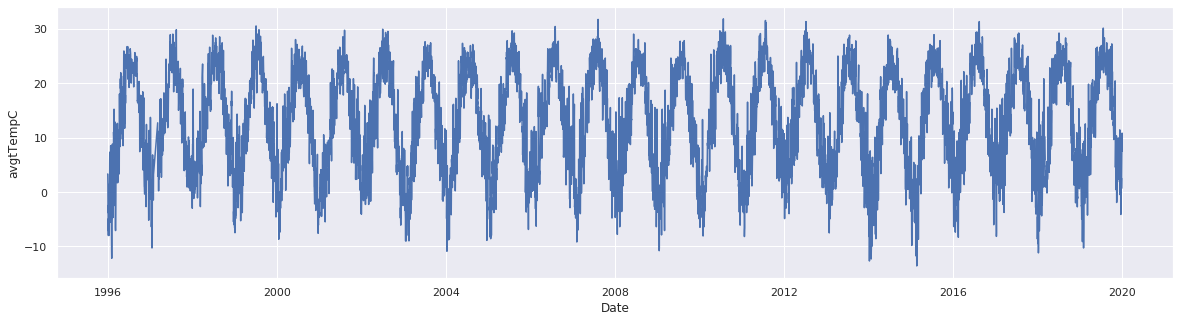

In [0]:
sns.set(style='darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax = sns.lineplot(x='Date', y='avgtTempC', data=weather_data)

Maximum Temperature (C)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


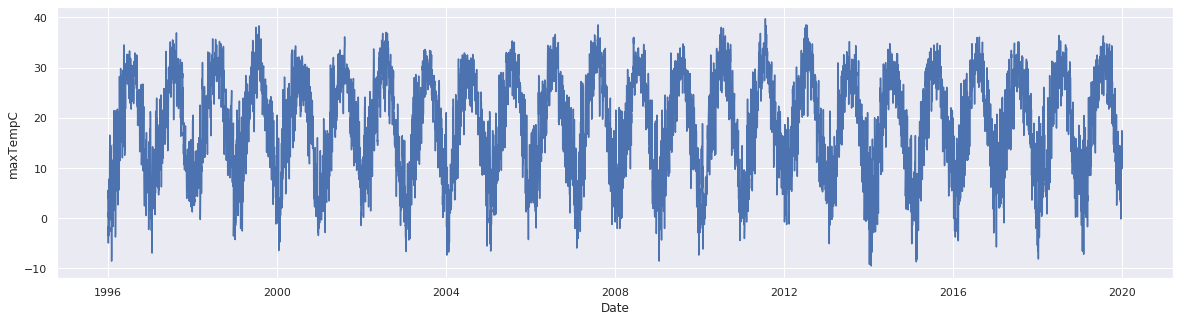

In [0]:
sns.set(style='darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax = sns.lineplot(x='Date', y='maxTempC', data=weather_data)

Minimum Temperature (C)

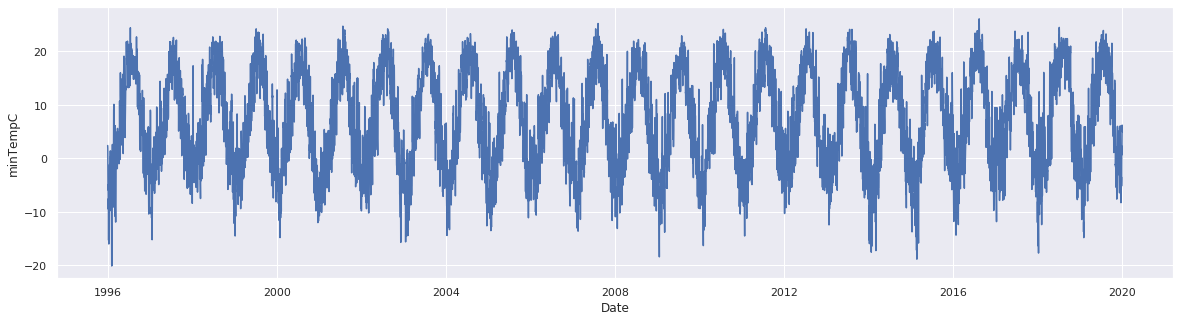

In [0]:
sns.set(style='darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax = sns.lineplot(x='Date', y='minTempC', data=weather_data)

Maximum Humidity (%)

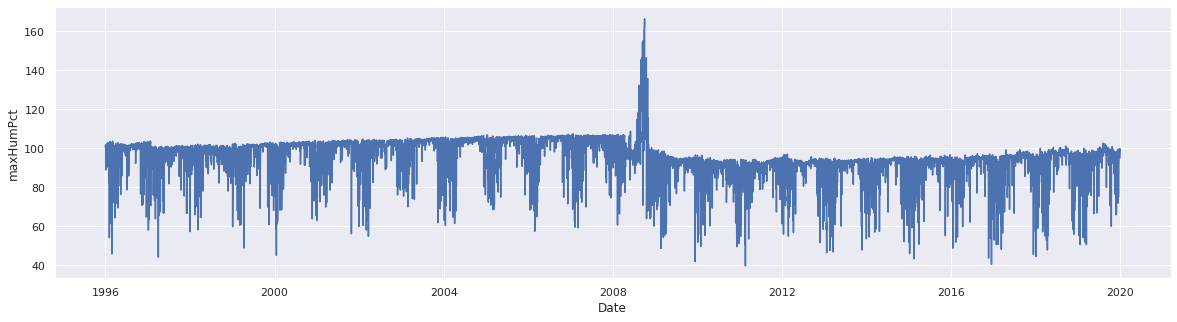

In [0]:
sns.set(style='darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax = sns.lineplot(x='Date', y='maxHumPct', data=weather_data)

Minimum Humidity (%)

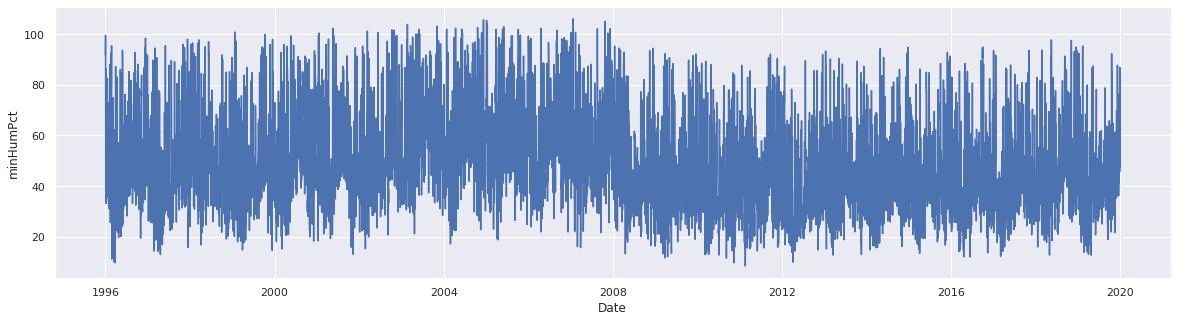

In [0]:
sns.set(style='darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax = sns.lineplot(x='Date', y='minHumPct', data=weather_data)

Average Radiation (W/m2)

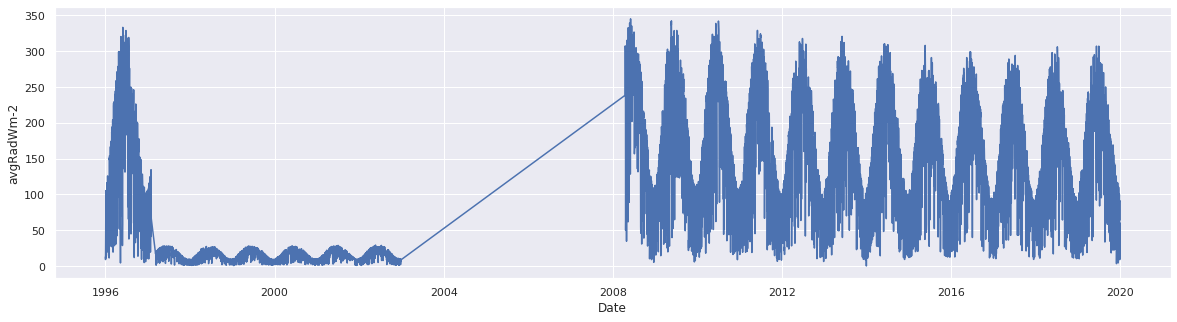

In [0]:
sns.set(style='darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax = sns.lineplot(x='Date', y='avgRadWm-2', data=weather_data)

Mean Wind (m/s)

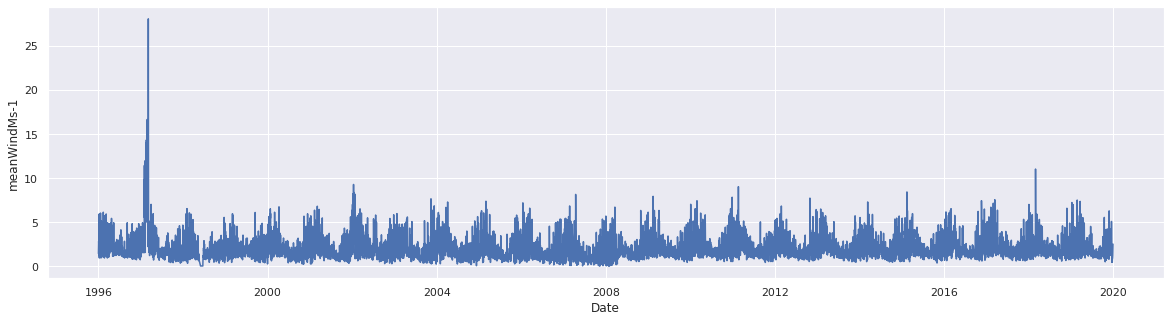

In [0]:
sns.set(style='darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax = sns.lineplot(x='Date', y='meanWindMs-1', data=weather_data)

Precipitation (mm)

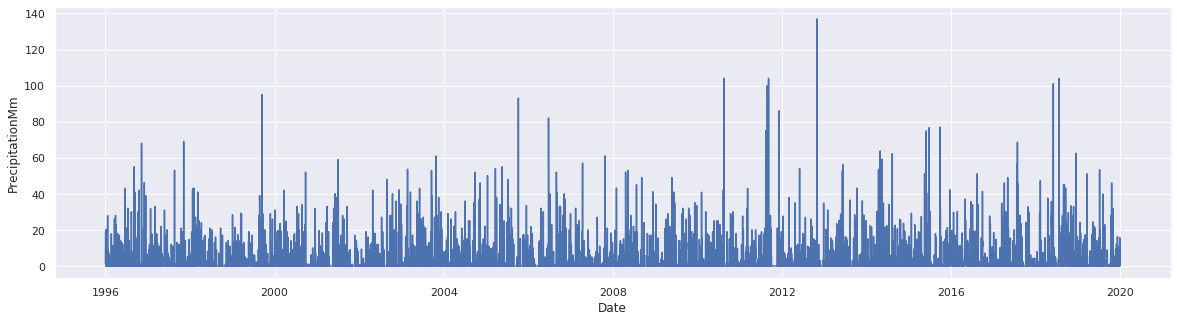

In [0]:
sns.set(style='darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax = sns.lineplot(x='Date', y='PrecipitationMm', data=weather_data)

Looking at the graphics, I will not use average radiation because data is missing for years 2003-2008.  I need to check the anomalies for maximum humidity and mean wind and how this can be corrected.

My next step is to work on feature engineering, I will combine crop mangement type in two categories traditional and organic.  After I determine the average number of weeks that takes for each crop to mature I will calculate weather variables weekly average starting from planting date.

I will also calculate growing degree days (GDD) that "are used to estimate the growth and development of plants and insects during the growing season. The basic concept is that development will only occur if the temperature exceeds some minimum development threshold, or base temperature (TBASE). The base temperatures are determined experimentally and are different for each organism". [1]

GDD formula for corn and soybean:

GDD = (Daily Max Temp °C + Daily Min Temp °C) / 2 - 10

GDD formula wheat:

GDD = (Daily Max Temp °C + Daily Min Temp °C) / 2 - 4.4


# References

1. Explanation of Growing Degree Days, Midwestern Regional Climate Center, mrcc.illinois.edu/gismaps/info/gddinfo.htm.